#### Prediction of missing eye tracking data with neural networks
Lucas D. Haberkamp<sup>1,2,3</sup>, Michael D. Reddix<sup>1</sup>

<sup>1</sup>Naval Medical Research Unit - Dayton  
<sup>2</sup>Oak Ridge Institute for Science and Education  
<sup>3</sup>Leidos   

---

This script trains a multi-layer perceptron to classify the gaze label from the 3D point of gaze coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

"extractdf" is a function which reads each file as a dataframe and saves the dataframe to a list and also saves a separate list of the filenames.

In [2]:
# fill_nan should be used with classification ground truth data. prevents a nan label.
def extractdf(data_path, fill_nan=False):
    file_list, df_list = [], [] # initialize lists
    for filename in os.listdir(data_path):
        f = os.path.join(data_path, filename) 
        if os.path.isfile(f):
            current_file = os.path.splitext(filename)[0].split('_')[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f)
            if fill_nan == True:
                tmp_df = tmp_df.fillna(0)
            df_list.append(tmp_df)

    return df_list, file_list

Extract the training and validation data for each file into separate lists for y_regression and y_classification, respectively.

In [3]:
# Specify paths
trainy_regression_path = '../Data/Prep/train/trainy-regression'
trainy_classification_path = '../Data/Prep/train/trainy-classification'

valy_regression_path = '../Data/Prep/validation/valy-regression'
valy_classification_path = '../Data/Prep/validation/valy-classification'

# Extract the data as dataframes stored into lists
trainy_regression_list, train_file_list = extractdf(trainy_regression_path)  
trainy_classification_list, _ = extractdf(trainy_classification_path, fill_nan=True)

valy_regression_list, val_file_list = extractdf(valy_regression_path)
valy_classification_list, _ = extractdf(valy_classification_path, fill_nan=True)

print("Files in the training dataset:", train_file_list)
print("Files in the validation dataset:", val_file_list)

Files in the training dataset: ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P09', 'P11', 'P12', 'P13', 'P14']
Files in the validation dataset: ['P06', 'P10']


Intialize separate MinMaxScaler objects for the inputs and outputs. Scales the data between 0 and 1. 

In [4]:
y_scaler = MinMaxScaler()

# fit data to the first file in the training dataset
y_scaler.fit(trainy_regression_list[0].values)

MinMaxScaler()

"batchdata" is a function to create random batches of data of a specified size for each classification 

In [2]:
def batchdata(y_reg, y_class, batch_size):
       
    # Initialize a new array for the batch of inputs.
    y_reg_batch, y_class_batch = [], []
            
    for k in range(batch_size):
        # Get a random index value.
        idx = np.random.randint(y_reg.shape[0])
            
        y_reg_batch.append(y_reg[idx])
        y_class_batch.append(y_class[idx])
        
    return np.array(y_reg_batch), np.array(y_class_batch)

"createsequences" is a function to create mini-sequences (has no nans), reshaping data for training and evaluating the model

In [6]:
def createsequences(y_reg_data, y_class_data, class_label):
    
    # initialize empty lists
    y_reg, y_class = [], []
    
    # extract non-nan sequences that include the classification label
    # (e.g., instrument panel, out the window, kneeboard) of interest
    for i in range(y_reg_data.shape[0]):
        if not np.isnan(y_reg_data[i]).any() and np.any(y_class_data[i] == class_label):
            y_reg.append(y_reg_data[i])
            y_class.append(y_class_data[i])
     
    if y_reg:
        return np.array(y_reg), np.array(y_class)

"finaldataprep" is a function which integrates the two functions above to prepare the datasets for training the neural network. The function returns 3D numpy arrays for the input, regression outputs, and classification outputs.

In [7]:
def finaldataprep(file_list, y_reg_list, y_class_list):
    
    # initialize empty lists
    y_reg_out, y_class_out = [], []
    # loop through the different object classifications and use the createsequences and 
    # batchdata functions to generate training data
    tmp_y_reg_ph, tmp_y_class_ph = [],[]
    sequence_size = []

    for _, class_label in enumerate(np.unique(y_class_list[0].values)):
        print("Current label is:", class_label)
        tmp_y_reg, tmp_y_class = [],[]
        for i in range(len(file_list)):
            y_reg_scaled = y_scaler.transform(y_reg_list[i].values) # MinMax Scale the y-regression data
            y_class = y_class_list[i].values
            # try to obtain sequences of the data for each file/object classification
            try:
                y_reg_seq, y_class_seq = createsequences(y_reg_scaled, y_class, class_label)
                print(file_list[i], y_reg_seq.shape)

                tmp_y_reg.append(y_reg_seq)
                tmp_y_class.append(y_class_seq)
            except Exception:
                print("Could not retrieve data for:", file_list[i])
        # concatenate x, y-regression, and y-classififcation lists into numpy arrays
        tmp_y_reg_ph.append(np.concatenate(tmp_y_reg, axis=0))
        tmp_y_class_ph.append(np.concatenate(tmp_y_class, axis=0))

        size_check = np.concatenate(tmp_y_reg, axis=0)
        sequence_size.append(size_check.shape[0])

    total_batch_size = max(sequence_size)
    for i, class_label in enumerate(np.unique(y_class_list[0].values)):
        batch_y_reg, batch_y_class = batchdata(tmp_y_reg_ph[i], tmp_y_class_ph[i], total_batch_size)
        print(i, "Train X Overall Shape =", batch_y_reg.shape,"\n")
        y_reg_out.append(batch_y_reg)
        y_class_out.append(batch_y_class)
            

    return (np.concatenate(y_reg_out, axis=0),
           np.concatenate(y_class_out, axis=0))

In [8]:
print("Gathering sequences for the training dataset.\n")
y_reg_train, y_class_train = finaldataprep(train_file_list, trainy_regression_list, trainy_classification_list)

# delete list to free space for memory
del trainy_regression_list, trainy_classification_list 

print("Gathering sequences for the validation dataset.\n")
# concatenate the validation data after selection of random sequences
y_reg_val, y_class_val = finaldataprep(val_file_list, valy_regression_list, valy_classification_list)

# delete list to free space for memory
del valy_regression_list, valy_classification_list 

Gathering sequences for the training dataset.

Current label is: 0.0
P01 (98, 3)
P02 (107, 3)
P03 (50, 3)
P04 (37, 3)
P05 (300, 3)
P07 (62, 3)
P08 (70, 3)
P09 (22, 3)
P11 (89, 3)
P12 (12, 3)
P13 (25, 3)
P14 (276, 3)
Current label is: 1.0
P01 (1194, 3)
P02 (2972, 3)
P03 (2169, 3)
P04 (8952, 3)
P05 (6620, 3)
P07 (5691, 3)
P08 (690, 3)
P09 (4300, 3)
P11 (3013, 3)
P12 (2586, 3)
P13 (512, 3)
P14 (7171, 3)
Current label is: 2.0
P01 (13914, 3)
P02 (24086, 3)
P03 (23042, 3)
P04 (16317, 3)
P05 (29277, 3)
P07 (33428, 3)
P08 (25769, 3)
P09 (6728, 3)
P11 (16874, 3)
P12 (12265, 3)
P13 (16578, 3)
P14 (16405, 3)
Current label is: 3.0
P01 (10582, 3)
P02 (9128, 3)
P03 (8926, 3)
P04 (4474, 3)
P05 (8381, 3)
P07 (7763, 3)
P08 (3111, 3)
P09 (9258, 3)
P11 (3592, 3)
P12 (11793, 3)
P13 (10382, 3)
P14 (6425, 3)
Current label is: 4.0
P01 (2933, 3)
P02 (7891, 3)
P03 (3843, 3)
P04 (3180, 3)
P05 (7622, 3)
P07 (7206, 3)
P08 (5912, 3)
P09 (9724, 3)
P11 (2642, 3)
P12 (10573, 3)
P13 (7079, 3)
P14 (7665, 3)
Current lab

Gather stats on the training and validation datasets.   
Including:  
-Counts for each classification label in the training dataset  
-Number of sequences in the training and validation datasets  
-Check for missing values in the training and validation datasets  
-Check the number of unique classification labels  

In [9]:
# count the number of datapoints in the training dataset for the instrument panel, out the window, and kneeboard, respectively.
ip_count = np.sum(y_class_train==0)
kb_count = np.sum(y_class_train==2)
outwin_count = np.sum(y_class_train==1)

print("Instrument Panel:", ip_count, "\nOut the Window:", outwin_count, "\nKneeboard:", kb_count)
print("The training data has", y_class_train.shape[0],"sequences.")
print("\nThe validation data has", y_class_val.shape[0],"sequences.")

# Check for nans in the training dataset
y_reg_train_nans = np.isnan(y_reg_train).any()
print("y_regression_train Missing values:", y_reg_train_nans)
y_class_train_nans = np.isnan(y_class_train).any()
print("y_classification_train Missing values:", y_class_train_nans)

# Check for nans in the validation dataset
y_reg_val_nans = np.isnan(y_reg_val).any()
print("y_regression_validation Missing values:", y_reg_val_nans)
y_class_val_nans = np.isnan(y_class_val).any()
print("y_classification_validation Missing values:", y_class_val_nans)

# check the number of unique classification labels
number_classes_train = np.unique(y_class_train)
print("\nAll classification labels in the training dataset:", number_classes_train)

number_classes_val = np.unique(y_class_train)
print("\nAll classification labels in the validation dataset:", number_classes_val)

Instrument Panel: 234683 
Out the Window: 234683 
Kneeboard: 234683
The training data has 3285562 sequences.

The validation data has 716506 sequences.
y_regression_train Missing values: False
y_classification_train Missing values: False
y_regression_validation Missing values: False
y_classification_validation Missing values: False

All classification labels in the training dataset: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]

All classification labels in the validation dataset: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


Construct the classifier, train the model, and assess the training performance. 

In [10]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [11]:
# Classification Model

# input layer
inputs = Input(shape=y_reg_train.shape[1])

hidden = Dense(16, activation="relu")(inputs)
hidden = Dense(16, activation="relu")(hidden)

# output layer
outputs = Dense(len(number_classes_train), activation='softmax', name="classification_output")(hidden)

# define the Model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 classification_output (Dens  (None, 14)               238       
 e)                                                              
                                                                 
Total params: 574
Trainable params: 574
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Set training parameters for the classifier
batch_size = 256
optimizer = Adam(lr=1e-3)
loss = 'sparse_categorical_crossentropy'
metrics = 'acc'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1, restore_best_weights=True)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [13]:
# Train the classification model
history = model.fit(y_reg_train, y_class_train,
                    validation_data=(y_reg_val, y_class_val),
                    batch_size=batch_size,
                    shuffle=True,
                    epochs=200,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/200
12835/12835 [==============================] - 17s 1ms/step - loss: 0.3068 - acc: 0.9323 - val_loss: 0.0755 - val_acc: 0.9837
Epoch 2/200
12835/12835 [==============================] - 18s 1ms/step - loss: 0.0300 - acc: 0.9941 - val_loss: 0.0232 - val_acc: 0.9986
Epoch 3/200
12835/12835 [==============================] - 18s 1ms/step - loss: 0.0122 - acc: 0.9980 - val_loss: 0.0131 - val_acc: 0.9993
Epoch 4/200
12835/12835 [==============================] - 18s 1ms/step - loss: 0.0075 - acc: 0.9988 - val_loss: 0.0081 - val_acc: 0.9998
Epoch 5/200
12835/12835 [==============================] - 19s 1ms/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0064 - val_acc: 0.9998
Epoch 6/200
12835/12835 [==============================] - 19s 1ms/step - loss: 0.0045 - acc: 0.9992 - val_loss: 0.0053 - val_acc: 0.9995
Epoch 7/200
12835/12835 [==============================] - 19s 2ms/step - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0047 - val_acc: 0.9999
Epoch 8/200
12835/12835 [=========

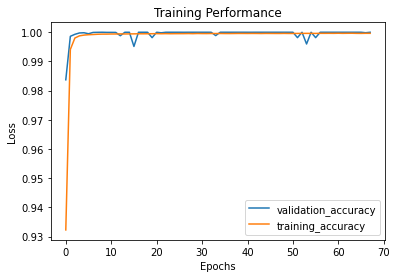

In [14]:
# Get training accuracy 
val_acc = history.history['val_acc']
acc = history.history['acc']

# Obtain number of epochs
epochs = range(len(acc))

# Plot loss and val loss
plt.plot(val_acc[0:], label='validation_accuracy')
plt.plot(acc[0:], label='training_accuracy')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [15]:
# Save model
model.save("../Models/Classifier")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/Classifier\assets
